In [1]:
!pip install "jcopdl<2.0.0"
!pip install gdown

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

In [4]:
!pip install gdown

In [5]:
!gdown https://drive.google.com/uc?id=1G7VwUtI5eN3dIOdemHgb_SPdrIB2q8pJ

Downloading...
From: https://drive.google.com/uc?id=1G7VwUtI5eN3dIOdemHgb_SPdrIB2q8pJ
To: /content/panorama.zip
100% 25.7M/25.7M [00:01<00:00, 21.5MB/s]


In [9]:
!unzip panorama.zip

Archive:  panorama.zip
   creating: data/
  inflating: data/test_label.csv     
  inflating: data/.DS_Store          
   creating: __MACOSX/
   creating: __MACOSX/data/
  inflating: __MACOSX/data/._.DS_Store  
   creating: data/test/
  inflating: data/test/1409.jpg      
   creating: __MACOSX/data/test/
  inflating: __MACOSX/data/test/._1409.jpg  
  inflating: data/test/1347.jpg      
  inflating: __MACOSX/data/test/._1347.jpg  
  inflating: data/test/1145.jpg      
  inflating: __MACOSX/data/test/._1145.jpg  
  inflating: data/test/360.jpg       
  inflating: __MACOSX/data/test/._360.jpg  
  inflating: data/test/1192.jpg      
  inflating: __MACOSX/data/test/._1192.jpg  
  inflating: data/test/374.jpg       
  inflating: __MACOSX/data/test/._374.jpg  
  inflating: data/test/1964.jpg      
  inflating: __MACOSX/data/test/._1964.jpg  
  inflating: data/test/1958.jpg      
  inflating: __MACOSX/data/test/._1958.jpg  
  inflating: data/test/572.jpg       
  inflating: __MACOSX/data/test/.

In [6]:
import jcopdl
jcopdl.__version__

'1.1.10'

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Dataset and Dataloader

In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import MultilabelDataset

In [11]:
bs = 64
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_set = MultilabelDataset("data/train_label.csv", "data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = MultilabelDataset("data/test_label.csv", "data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
label2cat = train_set.classes
label2cat

['desert', 'mountains', 'sea', 'sunset', 'trees']

# Arsitektur dan Config

### Contoh cara pakai pre-trained model

In [13]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

In [14]:
mnet = mobilenet_v2(weights=MobileNet_V2_Weights)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 104MB/s] 


In [15]:
for param in mnet.parameters():
    param.requires_grad = False

In [16]:
mnet

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [17]:
mnet.classifier = nn.Sequential(
    nn.Linear(1280, 5),
    nn.Sigmoid()
)

In [18]:
mnet

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [19]:
class CustomMobilenetV2(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.mnet = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        self.freeze()
        self.mnet.classifier = nn.Sequential(
            nn.Linear(1280, output_size),
            nn.Sigmoid()
        )


    def forward(self, x):
        return self.mnet(x)

    def freeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = False

    def unfreeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = True

In [20]:
config = set_config({
    "output_size": len(train_set.classes),
    "batch_size": bs,
    "crop_size": crop_size
})

## Phase 1: Adaptation (lr standard + patience kecil)

In [21]:
model = CustomMobilenetV2(config.output_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=2, outdir="model")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 56.0MB/s]


In [22]:
from tqdm import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/26 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Test: 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]



Epoch     1
Train_cost  = 0.5338 | Test_cost  = 0.4511 | 


Test: 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]



Epoch     2
Train_cost  = 0.4095 | Test_cost  = 0.3739 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]



Epoch     3
Train_cost  = 0.3558 | Test_cost  = 0.3409 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]



Epoch     4
Train_cost  = 0.3206 | Test_cost  = 0.3094 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]



Epoch     5
Train_cost  = 0.2985 | Test_cost  = 0.2902 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]



Epoch     6
Train_cost  = 0.2817 | Test_cost  = 0.2803 | 


Test: 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]



Epoch     7
Train_cost  = 0.2695 | Test_cost  = 0.2667 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]



Epoch     8
Train_cost  = 0.2570 | Test_cost  = 0.2633 | 


Test: 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]



Epoch     9
Train_cost  = 0.2567 | Test_cost  = 0.2563 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]



Epoch    10
Train_cost  = 0.2464 | Test_cost  = 0.2479 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]



Epoch    11
Train_cost  = 0.2409 | Test_cost  = 0.2396 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]



Epoch    12
Train_cost  = 0.2355 | Test_cost  = 0.2386 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]



Epoch    13
Train_cost  = 0.2336 | Test_cost  = 0.2332 | 


Test: 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]



Epoch    14
Train_cost  = 0.2273 | Test_cost  = 0.2273 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]



Epoch    15
Train_cost  = 0.2256 | Test_cost  = 0.2262 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  4.02it/s]



Epoch    16
Train_cost  = 0.2160 | Test_cost  = 0.2246 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]



Epoch    17
Train_cost  = 0.2118 | Test_cost  = 0.2248 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2246


Test: 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]



Epoch    18
Train_cost  = 0.2094 | Test_cost  = 0.2195 | 


Test: 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]



Epoch    19
Train_cost  = 0.2128 | Test_cost  = 0.2179 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]



Epoch    20
Train_cost  = 0.2075 | Test_cost  = 0.2207 | 


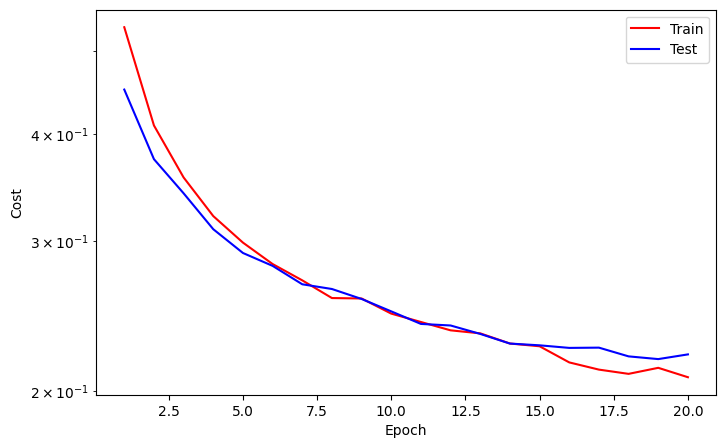

==> EarlyStop patience =  1 | Best test_cost: 0.2179


Test: 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]



Epoch    21
Train_cost  = 0.2040 | Test_cost  = 0.2180 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2179
==> Execute Early Stopping at epoch: 21 | Best test_cost: 0.2179
==> Best model is saved at model


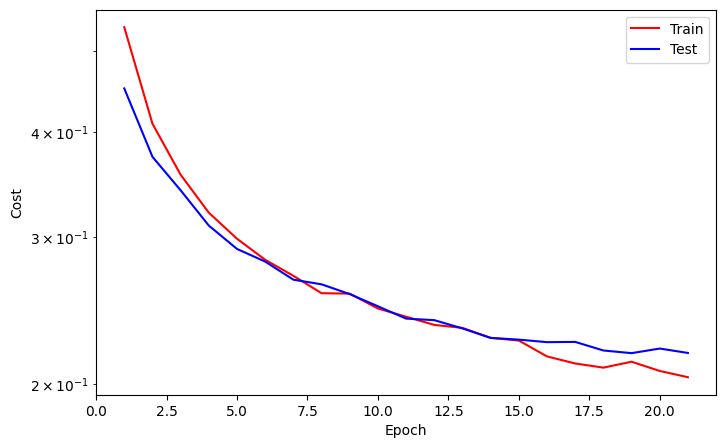

In [23]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Phase 2: Fine-tuning (lower lr + more patience)

In [24]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

callback.reset_early_stop()
callback.early_stop_patience = 5

Test: 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]



Epoch    22
Train_cost  = 0.2053 | Test_cost  = 0.2129 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]



Epoch    23
Train_cost  = 0.1947 | Test_cost  = 0.2122 | 


Test: 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]



Epoch    24
Train_cost  = 0.1919 | Test_cost  = 0.2050 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]



Epoch    25
Train_cost  = 0.1861 | Test_cost  = 0.2017 | 


Test: 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]



Epoch    26
Train_cost  = 0.1818 | Test_cost  = 0.2051 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2017


Test: 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]



Epoch    27
Train_cost  = 0.1786 | Test_cost  = 0.1987 | 


Test: 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]



Epoch    28
Train_cost  = 0.1777 | Test_cost  = 0.1946 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]



Epoch    29
Train_cost  = 0.1752 | Test_cost  = 0.1959 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1946


Test: 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]



Epoch    30
Train_cost  = 0.1741 | Test_cost  = 0.1960 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1946


Test: 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]



Epoch    31
Train_cost  = 0.1708 | Test_cost  = 0.1955 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1946


Test: 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]



Epoch    32
Train_cost  = 0.1647 | Test_cost  = 0.1884 | 


Test: 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]



Epoch    33
Train_cost  = 0.1632 | Test_cost  = 0.1922 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1884


Test: 100%|██████████| 7/7 [00:02<00:00,  2.87it/s]



Epoch    34
Train_cost  = 0.1613 | Test_cost  = 0.1893 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1884


Test: 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]



Epoch    35
Train_cost  = 0.1595 | Test_cost  = 0.1848 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]



Epoch    36
Train_cost  = 0.1619 | Test_cost  = 0.1861 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1848


Test: 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]



Epoch    37
Train_cost  = 0.1589 | Test_cost  = 0.1820 | 


Test: 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]



Epoch    38
Train_cost  = 0.1555 | Test_cost  = 0.1774 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]



Epoch    39
Train_cost  = 0.1539 | Test_cost  = 0.1759 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]



Epoch    40
Train_cost  = 0.1520 | Test_cost  = 0.1846 | 


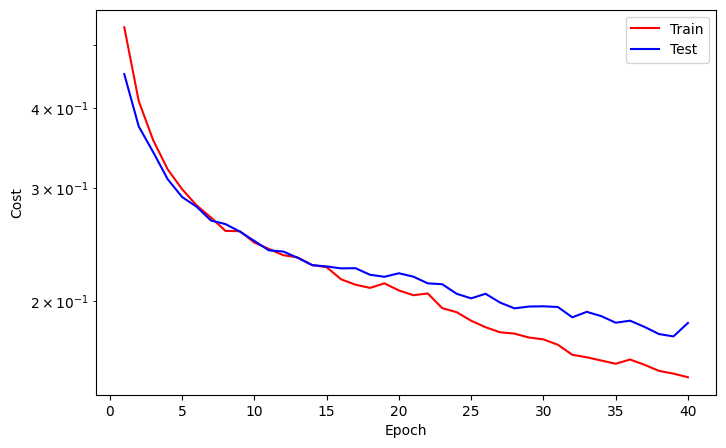

==> EarlyStop patience =  1 | Best test_cost: 0.1759


Test: 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]



Epoch    41
Train_cost  = 0.1476 | Test_cost  = 0.1786 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1759


Test: 100%|██████████| 7/7 [00:02<00:00,  3.36it/s]



Epoch    42
Train_cost  = 0.1514 | Test_cost  = 0.1785 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1759


Test: 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]



Epoch    43
Train_cost  = 0.1490 | Test_cost  = 0.1777 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1759


Test: 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]



Epoch    44
Train_cost  = 0.1435 | Test_cost  = 0.1739 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]



Epoch    45
Train_cost  = 0.1449 | Test_cost  = 0.1771 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1739


Test: 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]



Epoch    46
Train_cost  = 0.1433 | Test_cost  = 0.1731 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]



Epoch    47
Train_cost  = 0.1394 | Test_cost  = 0.1726 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]



Epoch    48
Train_cost  = 0.1391 | Test_cost  = 0.1722 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]



Epoch    49
Train_cost  = 0.1368 | Test_cost  = 0.1743 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1722


Test: 100%|██████████| 7/7 [00:02<00:00,  3.26it/s]



Epoch    50
Train_cost  = 0.1381 | Test_cost  = 0.1749 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1722


Test: 100%|██████████| 7/7 [00:01<00:00,  4.18it/s]



Epoch    51
Train_cost  = 0.1344 | Test_cost  = 0.1697 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]



Epoch    52
Train_cost  = 0.1366 | Test_cost  = 0.1652 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]



Epoch    53
Train_cost  = 0.1360 | Test_cost  = 0.1690 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1652


Test: 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]



Epoch    54
Train_cost  = 0.1326 | Test_cost  = 0.1654 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1652


Test: 100%|██████████| 7/7 [00:01<00:00,  4.20it/s]



Epoch    55
Train_cost  = 0.1316 | Test_cost  = 0.1719 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1652


Test: 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]



Epoch    56
Train_cost  = 0.1271 | Test_cost  = 0.1662 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1652


Test: 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]



Epoch    57
Train_cost  = 0.1252 | Test_cost  = 0.1645 | 


Test: 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]



Epoch    58
Train_cost  = 0.1283 | Test_cost  = 0.1644 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]



Epoch    59
Train_cost  = 0.1255 | Test_cost  = 0.1654 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1644


Test: 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]



Epoch    60
Train_cost  = 0.1222 | Test_cost  = 0.1663 | 


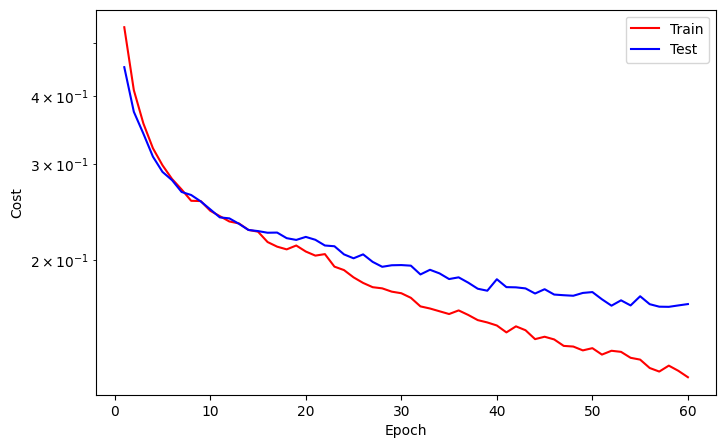

==> EarlyStop patience =  2 | Best test_cost: 0.1644


Test: 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]



Epoch    61
Train_cost  = 0.1234 | Test_cost  = 0.1615 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]



Epoch    62
Train_cost  = 0.1217 | Test_cost  = 0.1644 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1615


Test: 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]



Epoch    63
Train_cost  = 0.1220 | Test_cost  = 0.1633 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1615


Test: 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]



Epoch    64
Train_cost  = 0.1187 | Test_cost  = 0.1628 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1615


Test: 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]



Epoch    65
Train_cost  = 0.1157 | Test_cost  = 0.1679 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1615


Test: 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]



Epoch    66
Train_cost  = 0.1203 | Test_cost  = 0.1554 | 


Test: 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]



Epoch    67
Train_cost  = 0.1152 | Test_cost  = 0.1621 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1554


Test: 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]



Epoch    68
Train_cost  = 0.1110 | Test_cost  = 0.1576 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1554


Test: 100%|██████████| 7/7 [00:01<00:00,  4.02it/s]



Epoch    69
Train_cost  = 0.1128 | Test_cost  = 0.1598 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1554


Test: 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]



Epoch    70
Train_cost  = 0.1149 | Test_cost  = 0.1565 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1554


Test: 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]



Epoch    71
Train_cost  = 0.1106 | Test_cost  = 0.1591 | 
==> EarlyStop patience =  5 | Best test_cost: 0.1554
==> Execute Early Stopping at epoch: 71 | Best test_cost: 0.1554
==> Best model is saved at model


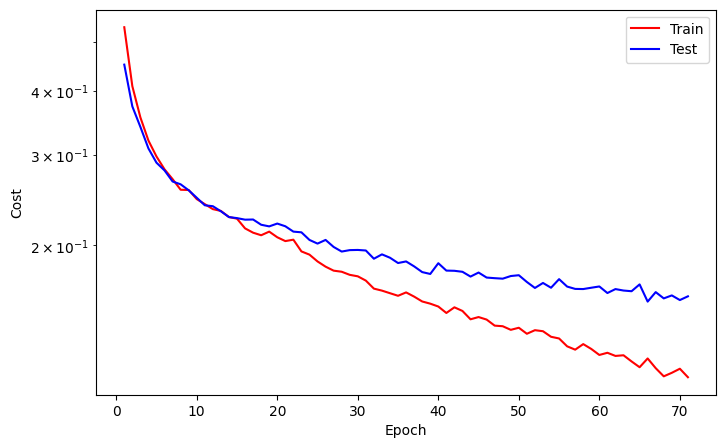

In [25]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Predict

In [26]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [27]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = (output > 0.5).to(torch.float32)

In [28]:
preds

tensor([[0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 1., 0.],
        [1., 0., 0., 1., 0.],
        [0., 1., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1.],
        [0., 1., 0., 0., 1.],
        [0., 0., 1., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0

# Sanity Check

In [29]:
def convert_to_label(x):
    return [label for pred, label in zip(x, label2cat) if pred==1]

def inverse_norm(img):
    img[0, :, :] = img[0, :, :] * 0.229 + 0.485
    img[1, :, :] = img[1, :, :] * 0.224 + 0.456
    img[2, :, :] = img[2, :, :] * 0.225 + 0.406
    return img

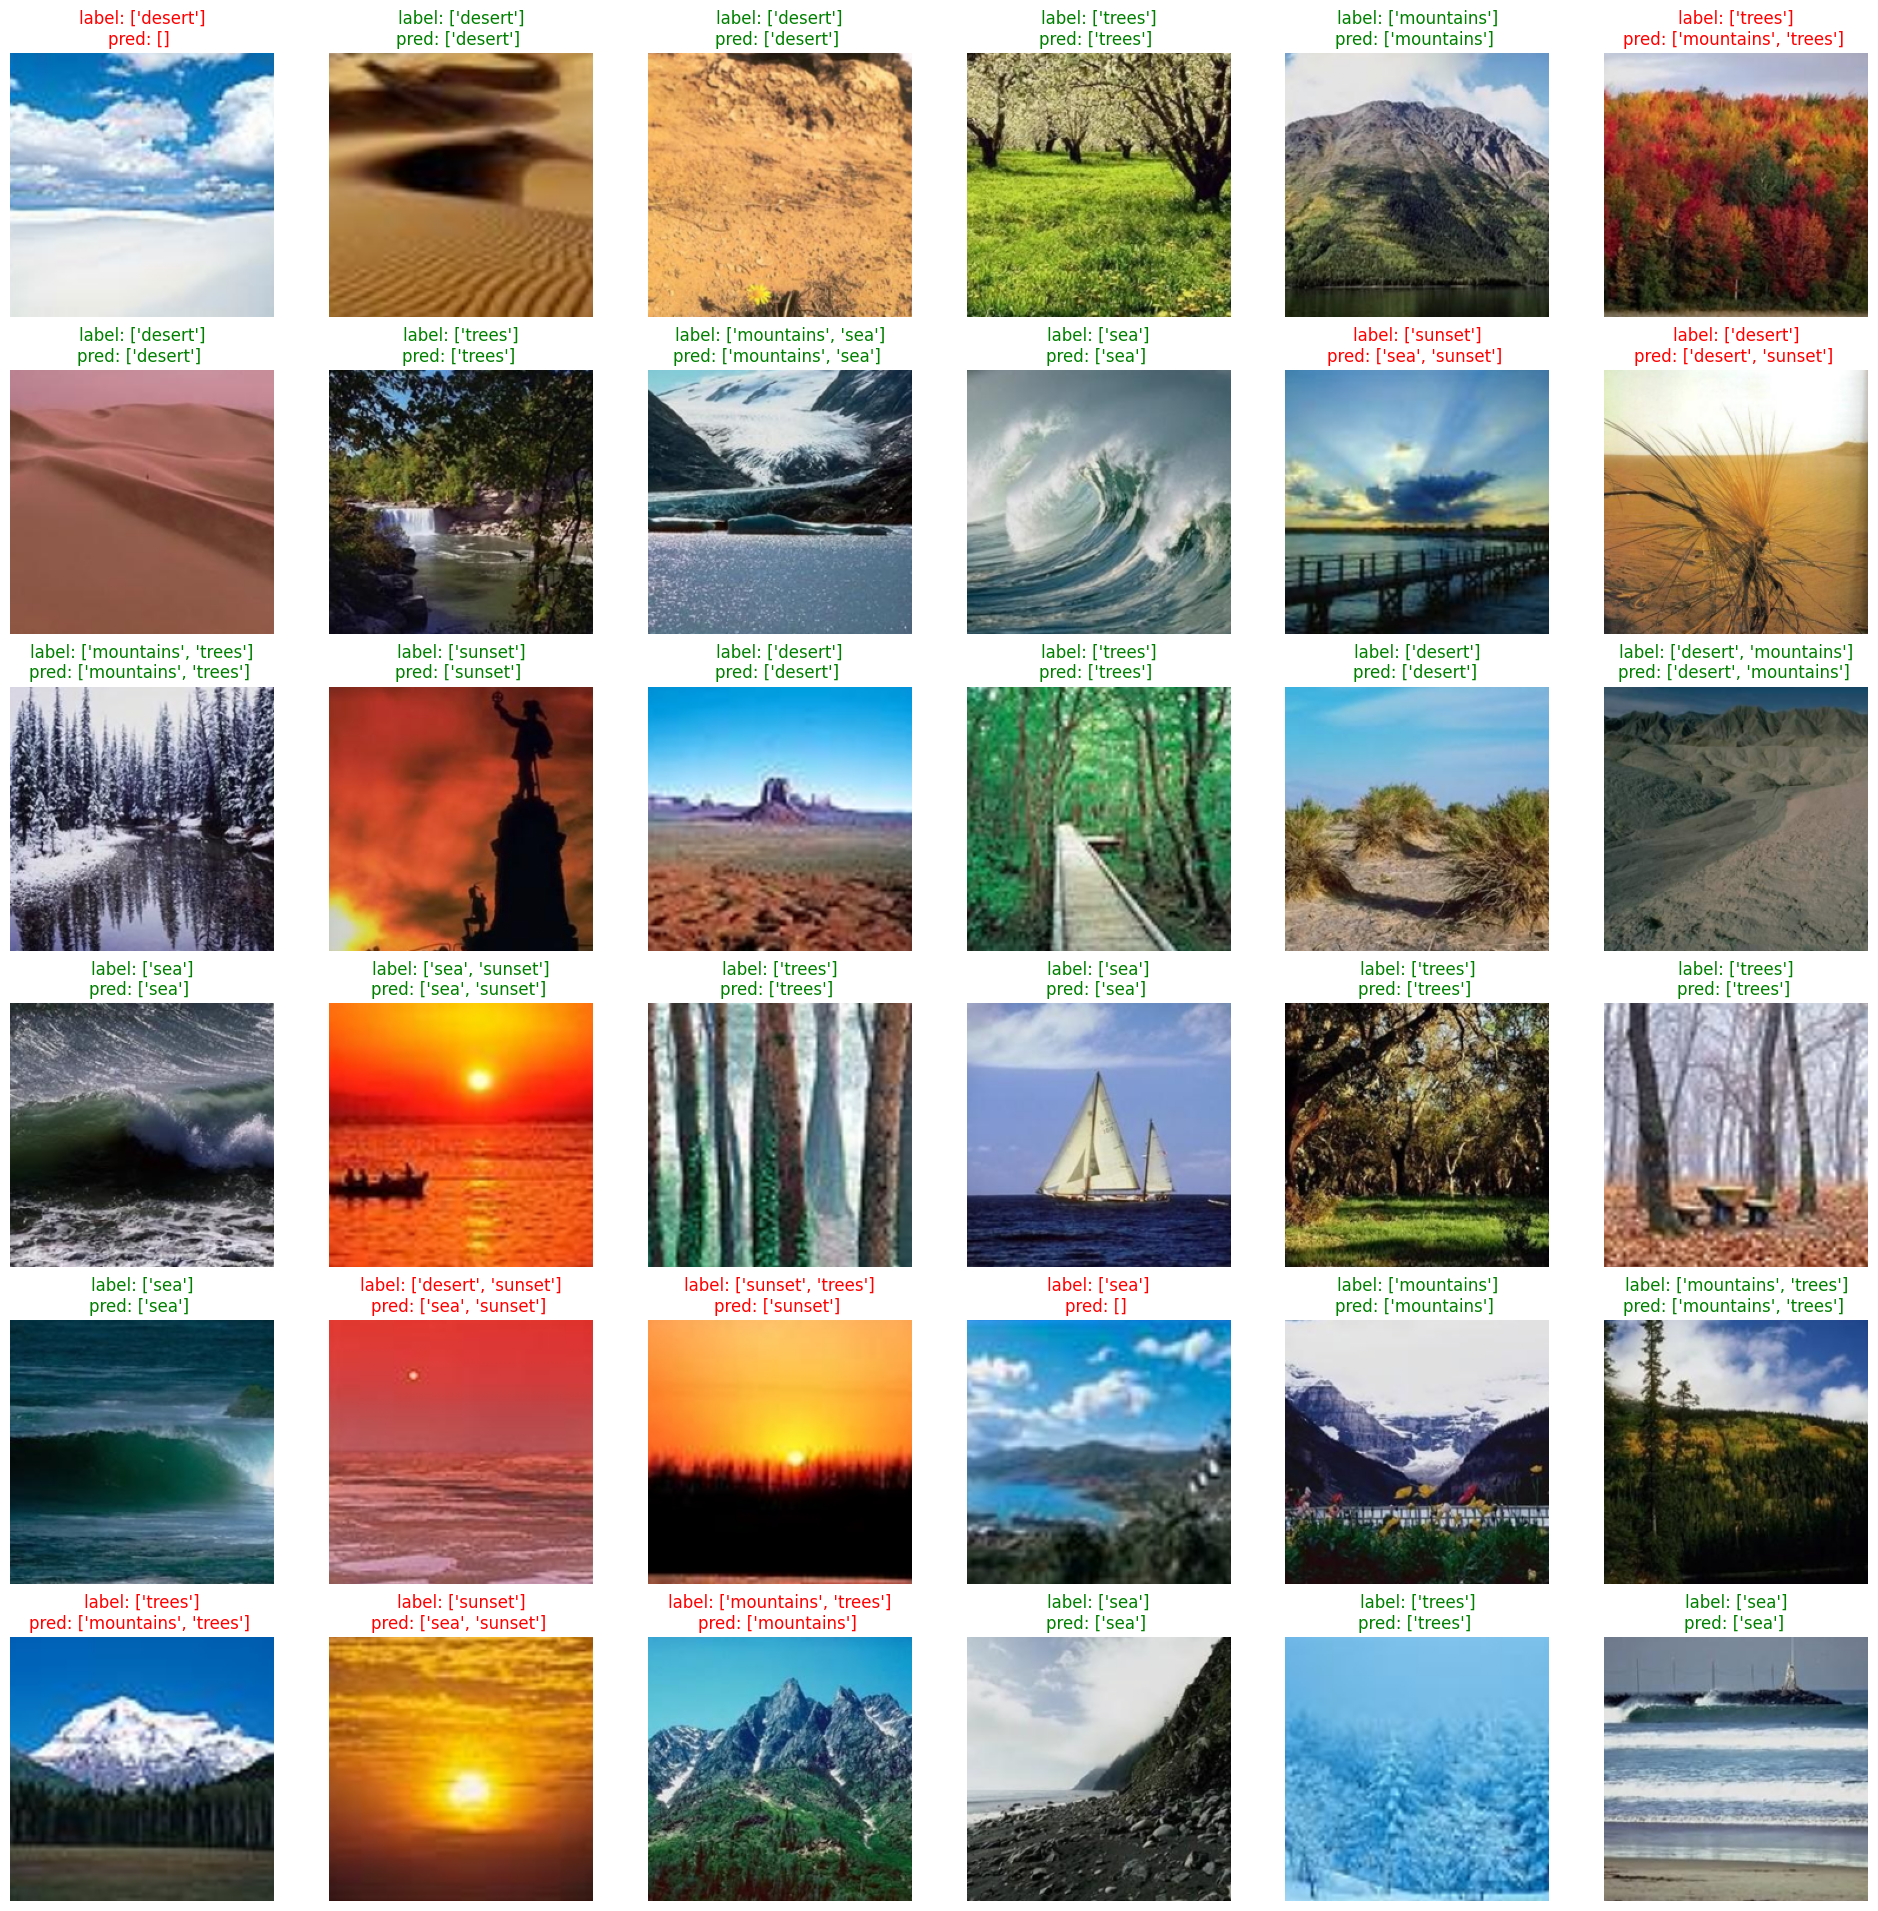

In [30]:
fig, axes = plt.subplots(6, 6, figsize=(24,24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(inverse_norm(img).permute(1, 2, 0).cpu())
    font = {"color": 'r'} if (pred != label).any() else {"color": 'g'}
    label, pred = convert_to_label(label), convert_to_label(pred)
    ax.set_title(f"label: {label}\npred: {pred} ", fontdict=font);
    ax.axis('off');

In [31]:
!zip -r model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/logs.pth (deflated 31%)
  adding: content/model/configs.pth (deflated 58%)
  adding: content/model/weights_50.pth (deflated 8%)
  adding: content/model/weights_best.pth (deflated 8%)
